In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import torch
# GPU 사용 가능하면 cuda, 아니면 cpu
import torchvision
import torchvision.transforms as transforms
from torch import Tensor
from typing import List, Tuple, Dict, Any, Union


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

60000
torch.Size([1, 28, 28]) 5


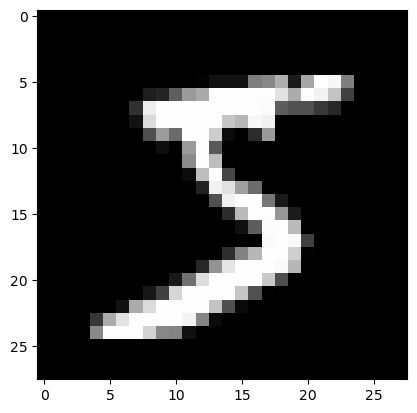

In [3]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

# NOTE

데이터 셋 구성

trainset[테스트 데이터 갯수][데이터와 정답, 튜플]
0 : 데이터 텐서
1 : 정답 값


In [4]:

print( type(trainset[0]))
print(len(trainset[0]))
print( type(trainset[0][0]))
print( type(trainset[0][1]))


<class 'tuple'>
2
<class 'torch.Tensor'>
<class 'int'>


첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [5]:
batch_size = 256



trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=False
)

In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


In [7]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))
    # x = self.layer3(x)


    return x


model = Model(28 * 28 * 1, 1024)

In [8]:
from torch.optim import SGD

lr = 0.0001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

In [9]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [10]:
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [11]:
train_accs = []
test_accs = []



n_epochs = 100
criterion = nn.CrossEntropyLoss()  # 분류 문제에 적합한 손실 함수



for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)

    loss = criterion(preds, labels)
    loss.backward()
    
    optimizer.step()

    total_loss += loss.item()
    # 리스트에 추가


  print(f"Epoch {epoch:3d} | Loss: {total_loss}")
  train_accs.append(accuracy(model, trainloader))
  test_accs.append(accuracy(model, testloader))

Epoch   0 | Loss: 541.027590751648
Epoch   1 | Loss: 540.8887839317322
Epoch   2 | Loss: 540.7384557723999
Epoch   3 | Loss: 540.5696382522583
Epoch   4 | Loss: 540.375022649765
Epoch   5 | Loss: 540.1532437801361
Epoch   6 | Loss: 539.9135687351227
Epoch   7 | Loss: 539.6709387302399
Epoch   8 | Loss: 539.435140132904
Epoch   9 | Loss: 539.2106502056122
Epoch  10 | Loss: 538.9973874092102
Epoch  11 | Loss: 538.7927424907684
Epoch  12 | Loss: 538.5940914154053
Epoch  13 | Loss: 538.3999781608582
Epoch  14 | Loss: 538.2092912197113
Epoch  15 | Loss: 538.0208585262299
Epoch  16 | Loss: 537.8338968753815
Epoch  17 | Loss: 537.6480257511139
Epoch  18 | Loss: 537.4628551006317
Epoch  19 | Loss: 537.2780447006226
Epoch  20 | Loss: 537.0933587551117
Epoch  21 | Loss: 536.9085834026337
Epoch  22 | Loss: 536.7236087322235
Epoch  23 | Loss: 536.5382931232452
Epoch  24 | Loss: 536.3525166511536
Epoch  25 | Loss: 536.1661732196808
Epoch  26 | Loss: 535.9791870117188
Epoch  27 | Loss: 535.791467428

In [15]:
import numpy as np

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

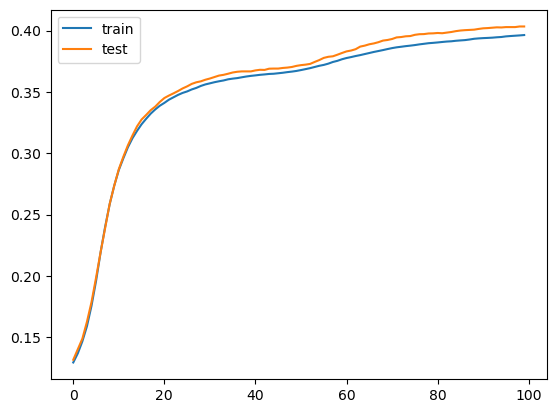

: 

In [ ]:
plot_acc(train_accs , test_accs)